## NuMI Analysis: numu/nue ratio study

#### Develop a numu selection for NuMI beam then do a numu/nue ratio study (inc energy + efficiency corrections) to constrain BNB low energy oscillation data.

First, setup.

In [1]:
%load_ext autoreload
%autoreload 2

#BDT

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)

#BDT

/home/alex/NuMI/PELEE/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

#BDT

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()
#print(numiBeamlineGeoWeights.calculateGeoWeight(14,0.01,5.))

#BDT

In [5]:
#test things are running

from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

#BDT

date and time: 03162022


In [6]:
# USING BDT?
USEBDT = True

In [7]:
# Doing Run3?
ISRUN3 = False

#BDT

In [8]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

#BDT

In [9]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

#BDT

In [10]:
# This cell is all about translating the BNB reference frame to the NuMI on axis reference frame
# You can skip it if you're not planning on using angle variables

from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

#BDT

Now get some data.

In [11]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

# Name of root files for the various samples
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""
BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""


#actually fetch datasets
mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [mc,nue,ext,data,dirt] 

# Define the variables you are going to load (less variables = less time)
# Some of them are common to all samples, others are present only in MC (like true variables)
# These are examples of variables common to all samples (there's more if you want!)

#To match Krishan's nue selection we need (1) nSlice (SliceID), n_showers_contained
#(2) xyz for reconstructed vertex, contained fraction of hits (3) cosmic impact params
#(4) hit ratio of leading shower to slice (5) moliere angle av, dEdx in first 4cm of shower, shower to vertex dist
#"shower_vtx_dist" not working?
#shr_energy, category, slnunhits, slnhits, slash time, ccnc, nu pdg needed later
variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy']

"""
varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
"""

# These are examples of variables present in MC samples only
varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
variables = list(set(variables))
print(variables)


# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


# Load the variables into your dataframes    
dirt = dirt.pandas.df(variables+varMC + WEIGHTS + SYSTEMATICS, flatten=False)
nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
mc   = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext  = ext.pandas.df(variables, flatten=False)

#BDT

['shr_energy', 'reco_nu_vtx_sce_x', 'tksh_angle', 'tksh_distance', 'slnhits', 'topological_score', 'nslice', 'trkshrhitdist2', 'shrsubclusters2', 'ccnc', 'evt', 'n_tracks_contained', 'sub', 'shr_tkfit_dedx_U', 'nu_pdg', 'nproton', 'shr_tkfit_dedx_V', 'shr_energy_cali', 'shrsubclusters0', 'trk_energy', 'run', 'slnunhits', 'trk_score_v', 'flash_time', 'category', 'shrsubclusters1', 'n_showers', 'shr_tkfit_nhits_Y', 'shr_distance', 'trk_energy_tot', 'n_tracks', 'contained_fraction', 'hits_ratio', 'shr_energy_tot_cali', 'shr_tkfit_dedx_Y', 'selected', 'n_showers_contained', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'shrmoliereavg', 'shr_tkfit_nhits_V', 'shr_tkfit_nhits_U', 'shr_score', 'shr_tkfit_npoints', 'CosmicIPAll3D']


The following cell allows us to reload original data event weights. No weights have been added to data or ext so these are not included.

In [12]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    
#BDT

In [13]:
# Let's calculate the weights that we need to apply to the individual MC events 
# to become our best model of the NuMI data. 
# This cell calculates the GENIE Tune * PPFX correction to the MC weights and 
# cleans up extremely high (or low) weight scores (may be due to computational errors).
# The clean up is not the best practice (one should dig and understand why the weight are big/negative): 
# it's a cheat until we figure out the next best thing. Life is not perfect and your analysis won't be either. Please enojy LArbys

constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [mc,nue,dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

#BDT

Get Log Likelihood Ratio Particle ID for track candidates. Will need proton for nue, muon for numu.

In [14]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [mc,nue,ext,data,dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

#BDT

time to run:  419.40897154808044


In [15]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    #
    # secondshower_U/V/Y_dot need to be set to 9999. to match data ntuples produced with v08_00_00_43 or later;
    # the patch below is valid only to match data ntuples produced with v08_00_00_42.
    #
    #df.loc[df['secondshower_U_dot'].isna(),'secondshower_U_dot'] = 0.0 #for 0p please uncomment
    #df.loc[df['secondshower_V_dot'].isna(),'secondshower_V_dot'] = 0.0 #for 0p please uncomment
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 
    
#BDT

In [16]:
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
#    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
#    df['shr_tkfit_nhi'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
#    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
#    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
#    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
#    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    
    #BDT

In [17]:
#commented big tutorial had flash timer just before this

#Define neutrino reconstructed energy here
#Also make a correction to electron shower energies

INTERCEPT = 0.0
SLOPE = 0.83

df_v = [mc,nue,ext,data,dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])


#BDT

In [18]:
# add back the cosmic category, for background only
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    
#BDT    

In [19]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        
#BDT        

In [20]:
#Define signal catagories

data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11

nue["is_not_signal"] = nue["category"] != 11

#BDT

In [21]:
# Some quick clean up since some strange events get in there
mc   = mc.query('nu_e > 0.')
nue  = nue.query('nu_e > 0.')
dirt = dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [mc,nue,dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    


## Selection Section

In [22]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

print(PRESQ)

nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)


In [24]:
# Define actual selection

#QUERY = PRESQ
#QUERY = NPLCUTQ +" and "+ BDTCQ #PI0SEL#NUMUOnTheFly + ' and n_showers_contained == 1'  #PI0SEL#NPLCUTQ2 #NPLCUTQ #NPPRESQ#'nslice ==1 ' #NPPRESQ #PRESQ

# in case you do not want to look at the data
#QUERY += ' and bnbdata==0'

# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [23]:
df_v = [mc,nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

## MC Truth

In [24]:
truthsel  = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5")
print(truthsel.size)

truthbin1 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 0.04 and nu_e < 0.5)")
truthbin2 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 0.5 and nu_e < 1.0)")
truthbin3 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 1.0 and nu_e < 1.5)")
truthbin4 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 1.5 and nu_e < 2.0)")
truthbin5 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 2.0 and nu_e < 2.5)")
truthbin6 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 2.5 and nu_e < 3.0)")
truthbin7 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 3.0 and nu_e < 3.5)")
truthbin8 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 3.5 and nu_e < 4.0)")
truthbin9 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 4.0 and nu_e < 4.5)")
truthbin10 = nue.query("(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e >= 4.5 and nu_e < 5.0)")

ratiotruths = [truthbin1.size, truthbin2.size, truthbin3.size, truthbin4.size, truthbin5.size, truthbin6.size, truthbin7.size, truthbin8.size, truthbin9.size, truthbin10.size]
print(ratiotruths)

9265850
[548570, 3105630, 2737460, 1346730, 678590, 376420, 232760, 129800, 74690, 35200]


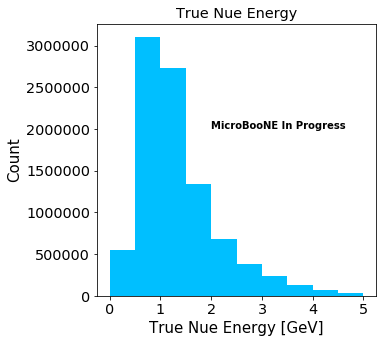

In [24]:
import matplotlib.pyplot as plt
import matplotlib

nue_truth = [548570, 3105630, 2737460, 1346730, 678590, 376420, 232760, 129800, 74690, 35200]
count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
weights = [0.1*nue_truth[0], 0.6*nue_truth[1], 1.1*nue_truth[2], 1.6*nue_truth[3], 2.1*nue_truth[4], 2.6*nue_truth[5], 3.1*nue_truth[6], 3.6*nue_truth[7], 4.1*nue_truth[8], 4.6*nue_truth[9]]
bins = np.arange(0, 5.5, 0.5)    
    
# plot selected signal events 
fig, ax1 = plt.subplots(figsize=(5, 5))
    
sel = ax1.hist(count, bins, color='deepskyblue', weights=nue_truth)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xlabel('True Nue Energy [GeV]', fontsize=15)
#ax1.set_ylim(0, 3500)
ax1.set_title("True Nue Energy")
    
plt.text(2, 2000000, r'MicroBooNE In Progress', fontweight='bold')
plt.show()

In [70]:
numu_ratio_nums_truth = [2407340, 4994210, 5023720, 4070430, 2104960, 1013480, 647920, 443430, 278330, 191360]
nue_ratio_nums_truth = [548570, 3105630, 2737460, 1346730, 678590, 376420, 232760, 129800, 74690, 35200]
bin_ratios_truth = []

for i in range(len(numu_ratio_nums_truth)):
    ratio = nue_ratio_nums_truth[i]/numu_ratio_nums_truth[i]
    bin_ratios_truth.append(ratio)
    
print(bin_ratios_truth)

[0.22787391893126854, 0.6218460977812307, 0.5449069613752359, 0.33085693649073933, 0.3223766722408027, 0.37141334806804277, 0.35924188171379184, 0.2927181291297386, 0.2683505191678942, 0.18394648829431437]


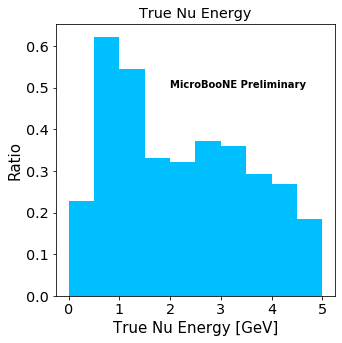

In [72]:
import matplotlib.pyplot as plt
import matplotlib

count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
weights = [0.1*bin_ratios_truth[0], 0.6*bin_ratios_truth[1], 1.1*bin_ratios_truth[2], 1.6*bin_ratios_truth[3], 2.1*bin_ratios_truth[4], 2.6*bin_ratios_truth[5], 3.1*bin_ratios_truth[6], 3.6*bin_ratios_truth[7], 4.1*bin_ratios_truth[8], 4.6*bin_ratios_truth[9]]
bins = np.arange(0, 5.5, 0.5)    
    
# plot selected signal events 
fig, ax1 = plt.subplots(figsize=(5, 5))
    
sel = ax1.hist(count, bins, color='deepskyblue', weights=bin_ratios_truth)
ax1.set_ylabel('Ratio', fontsize=15)
ax1.set_xlabel('True Nu Energy [GeV]', fontsize=15)
#ax1.set_ylim(0, 3500)
ax1.set_title("True Nu Energy")
    
plt.text(2, 0.5, r'MicroBooNE Preliminary', fontweight='bold')
plt.show()

## Plotting Part

In [25]:
import plotter
import importlib
importlib.reload(plotter)
scaling = 1

SPLIT = 1.0
####Is this needed of new BDT?
#if (USEBDT == True):
#    SPLIT = 2.

#Define the samples to feed the plotter, as well as POT normalisation for each sample
#Need MC to be compariable to the data

#fullnue = nue
#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
# 254.8 & true_nu_vtx_x > -1.55 )")
#This is abs as it defines the dataset. shouldn' need here?
#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
#nue   = nue.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 #254.8 & true_nu_vtx_x > -1.55)")


samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "dirt": dirt,
    "ext": ext
}

scaling = 1
# This is the data POT we normalize to (comes from the data Ntuples)
pot =  2e+20 #partial file: 8.885e+19
# This is the full MC POT scaling factor
mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
# This is the POT scaling factor for the nue CC only sample
nueratio  = pot/2.37838e+22 #2.59311e+22 #norm for intrinsic = 2.59311e+22
# This is the POT scaling factor for dirt sample
dirtratio = pot/1.42143e+21
# The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
SPLIT = 1.0
# We scale down the EXT to account for neutrino occupancy
scalingEXT = 0.98
 # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
scalingDRT = 0.35


#Now we can define the sample normalization factors
weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}

print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

#BDT

904362
{'mc': 0.08559738414394057, 'nue': 0.008409085175623745, 'ext': 0.5612087579382191, 'dirt': 0.049246181662128984}


Pre Selection Plots.

true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0& nu_e <= 5 & nu_e >= 0.04 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  0.0443392238133847  c  31
order w sum  0.10191528771429013  c  3
order w sum  9.319746696363522  c  4
order w sum  53.640950550728384  c  5
order w sum  146.06896419823548  c  0
order w sum  155.54777082220934  c  1
order w sum  0  c  12
order w sum  370.8856763625695  c  11
[0.02558536 0.01875386 0.         0.         0.         0.
 0.         0.         0.         0.        ]
sum:  0.044339223813384704
[0.04907173 0.07009149 0.01901767 0.00807363 0.         0.
 0.         0.         0.         0.        ]
sum:  0.14625451152767488
[1.00513932 3.46181073 2.4424802  1.13061445 0.65441282 0.28624796
 0.24581635 0.10481811 0.11061994 0.02404134]
sum:  9.466001207891212
[ 4.63345345 22.15197797 18.2765142

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/NuMI/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc

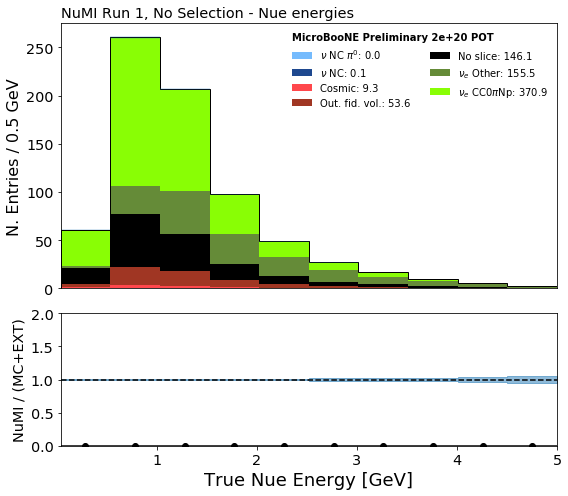

In [25]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'nu_e', 10, (0.04,5.0), r"True Nue Energy [GeV]"

#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= FID_QUERY ,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = False, # need this to plot MC!
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Nue energies',loc='left')
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/"+VARIABLE+"_varCV.pdf")
#print('%s %.4f %.4f %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag'])+"\n")

In [1]:
######################

## BDT

In [26]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [27]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [28]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [mc, nue, dirt, ext, data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(914729, 110)
(127551, 111)
(483722, 92)
(904362, 64)
(610496, 64)


In [29]:
datasets_bdt = mc

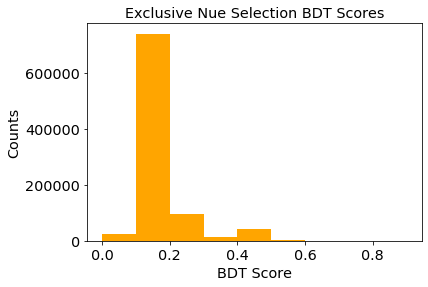

In [30]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

## BDT Variable Validation

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12& shr_score <= 0.5 & shr_score >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  7.062867097808422  c  5
order w sum  7.327092618258835  c  3
order w sum  9.41698639417735  c  21
order w sum  11.622348238073027  c  2
order w sum  15.055693968545132  c  4
order w sum  31.403006513185307  c  31
order w sum  15.106247147697962  c  1
order w sum  7.258208614673398  c  12
order w sum  86.6759691334522  c  11
total  237.50874663474372
[3.442 1.171 1.088 0.477 0.529 0.356 0.    0.    0.    0.   ]
sum:  7.062867097808418
[6.243 2.708 1.813 1.208 1.475 0.942 0.    0.    0.    0.   ]
sum:  14.389959716067256
[12.226  3.984  3.105  1.298  1.825  1.369  

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys
n_data  [142  20  16   9  11  10   0   0   0   0]


/home/alex/NuMI/PELEE/plotter.py:267: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / data
/home/alex/NuMI/PELEE/plotter.py:263: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / mc
/home/alex/NuMI/PELEE/plotter.py:257: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/home/alex/NuMI/PELEE/plotter.py:2281: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


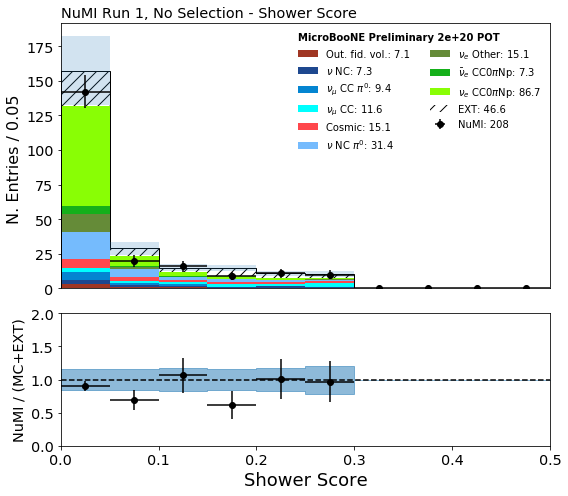

In [63]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'shr_score', 10, (0.0,0.5), r"Shower Score"

#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= BDT_LOOSE_CUTS,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True, 
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Shower Score',loc='left')
fig.tight_layout()

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12& shrmoliereavg <= 15 & shrmoliereavg >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  7.062867097808422  c  5
order w sum  7.327092618258835  c  3
order w sum  9.41698639417735  c  21
order w sum  11.622348238073027  c  2
order w sum  15.055693968545132  c  4
order w sum  31.403006513185307  c  31
order w sum  15.106247147697962  c  1
order w sum  7.258208614673398  c  12
order w sum  86.6759691334522  c  11
total  237.50874663474372
[0.    0.115 0.106 0.333 0.735 0.722 0.74  1.04  0.58  0.517 0.445 0.542
 0.647 0.246 0.296]
sum:  7.062867097808417
[0.    0.254 0.189 0.398 1.179 0.936 1.626 1.892 1.323 0.953 1.192 0.859
 1.656 1.004 0.931]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys
n_data  [ 0  5 12 27 28 27 23 17 14 18  7  8  9  6  8]


/home/alex/NuMI/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/alex/NuMI/PELEE/plotter.py:267: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


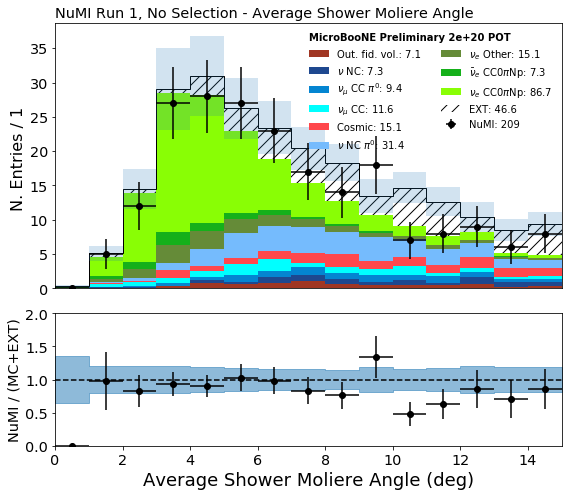

In [64]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'shrmoliereavg', 15, (0.0,15.0), r"Average Shower Moliere Angle (deg)"

#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= BDT_LOOSE_CUTS,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True, 
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Average Shower Moliere Angle',loc='left')
fig.tight_layout()

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  7.062867097808422  c  5
order w sum  7.327092618258835  c  3
order w sum  9.41698639417735  c  21
order w sum  11.622348238073027  c  2
order w sum  15.055693968545132  c  4
order w sum  31.403006513185307  c  31
order w sum  15.106247147697962  c  1
order w sum  7.258208614673398  c  12
order w sum  86.6759691334522  c  11
total  237.50874663474372
[0.373 0.303 0.241 0.318 1.225 2.669 1.934 0.    0.    0.   ]
sum:  7.062867097808422
[1.267 2.431 0.789 1.191 2.169 4.008 2.535 0.    0.    0.   ]
sum:  14.389959716067258
[2.441 5.063 1.832 1.745 3.689 5.664 3.373 0.    0.    0.   ]
sum:  23.80694611

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/NuMI/PELEE/plotter.py:257: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)


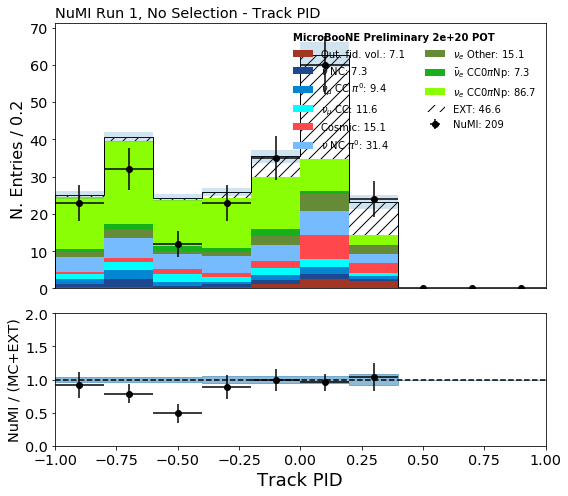

In [47]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'trkpid', 10, (-1.0,1.0), r"Track PID"

reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERYB = 'nslice==1'
BDT_PRE_QUERYB += ' and ' + reco_in_fv_query
BDT_PRE_QUERYB +=' and contained_fraction>0.9'
BDT_PRE_QUERYB += ' and n_tracks_contained>0'
BDT_PRE_QUERYB += ' and n_showers_contained==1' #one
BDT_PRE_QUERYB += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERYB += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTSB = BDT_PRE_QUERYB
BDT_LOOSE_CUTSB += ' and shr_score<0.3'
BDT_LOOSE_CUTSB += ' and trkpid<0.35'
BDT_LOOSE_CUTSB += ' and shrmoliereavg<15' #one
BDT_LOOSE_CUTSB += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTSB += ' and tksh_distance<12'

#OPEN_QUERY = "trkpid > -5"

#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= BDT_LOOSE_CUTSB,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True, 
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Track PID',loc='left')
fig.tight_layout()

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12& n_showers_contained <= 10 & n_showers_contained >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  7.062867097808422  c  5
order w sum  7.327092618258835  c  3
order w sum  9.41698639417735  c  21
order w sum  11.622348238073027  c  2
order w sum  15.055693968545132  c  4
order w sum  31.403006513185307  c  31
order w sum  15.106247147697962  c  1
order w sum  7.258208614673398  c  12
order w sum  86.6759691334522  c  11
total  237.50874663474372
[0.    7.063 0.    0.    0.    0.    0.    0.    0.    0.   ]
sum:  7.06286709780842
[ 0.   14.39  0.    0.    0.    0.    0.    0.    0.    0.  ]
sum:  14.389959716067256
[ 0.    23.807  0.     0. 

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys
n_data  [  0 209   0   0   0   0   0   0   0   0]


/home/alex/NuMI/PELEE/plotter.py:267: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / data
/home/alex/NuMI/PELEE/plotter.py:263: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / mc
/home/alex/NuMI/PELEE/plotter.py:257: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/home/alex/NuMI/PELEE/plotter.py:2281: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


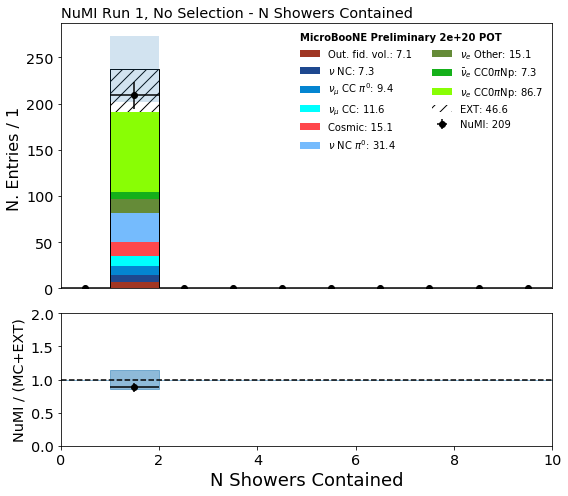

In [67]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained', 10, (0.0,10.0), r"N Showers Contained"

#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= BDT_LOOSE_CUTS,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True, 
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - N Showers Contained',loc='left')
fig.tight_layout()

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12& shr_tkfit_dedx_Y <= 10 & shr_tkfit_dedx_Y >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  7.062867097808422  c  5
order w sum  7.327092618258835  c  3
order w sum  9.41698639417735  c  21
order w sum  11.622348238073027  c  2
order w sum  15.055693968545132  c  4
order w sum  31.403006513185307  c  31
order w sum  15.106247147697962  c  1
order w sum  7.258208614673398  c  12
order w sum  86.6759691334522  c  11
total  237.50874663474372
[0.548 1.744 2.403 1.063 0.72  0.4   0.184 0.    0.    0.   ]
sum:  7.062867097808418
[1.052 3.064 4.757 2.033 1.822 0.974 0.688 0.    0.    0.   ]
sum:  14.389959716067253
[1.17  4.276 7.005 3.855 4.002 

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys
n_data  [12 53 72 29 23 12  8  0  0  0]


/home/alex/NuMI/PELEE/plotter.py:267: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / data
/home/alex/NuMI/PELEE/plotter.py:263: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / mc
/home/alex/NuMI/PELEE/plotter.py:257: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/home/alex/NuMI/PELEE/plotter.py:2281: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


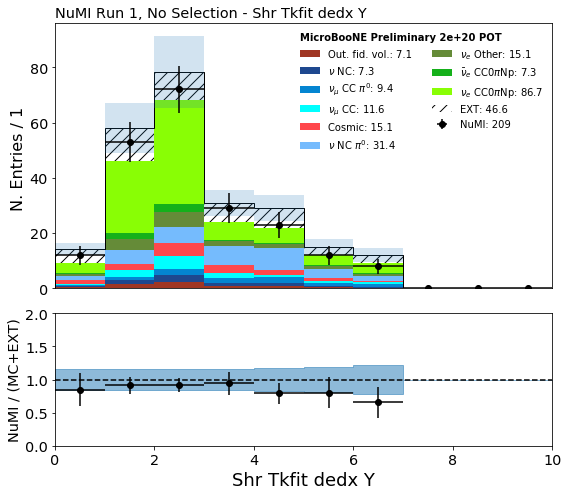

In [68]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'shr_tkfit_dedx_Y', 10, (0.0,10.0), r"Shr Tkfit dedx Y"

#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= BDT_LOOSE_CUTS,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True, 
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Shr Tkfit dedx Y',loc='left')
fig.tight_layout()

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12& tksh_distance <= 10 & tksh_distance >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  6.631794198407458  c  5
order w sum  6.741353137351949  c  3
order w sum  7.941212220888772  c  21
order w sum  11.303785661562527  c  2
order w sum  14.743418791766185  c  4
order w sum  28.126606102634053  c  31
order w sum  14.768618093949511  c  1
order w sum  7.078356643076888  c  12
order w sum  85.07531735592072  c  11
total  227.86837159855375
[1.171 2.055 1.215 0.758 0.658 0.029 0.161 0.376 0.15  0.059]
sum:  6.631794198407451
[2.865 3.98  2.295 0.958 0.877 0.787 0.435 0.449 0.413 0.312]
sum:  13.373147335759395
[3.656 5.288 3.47  1.792 1.38  1.23

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys
n_data  [66 49 27 19  9 11  5  5  4  8]


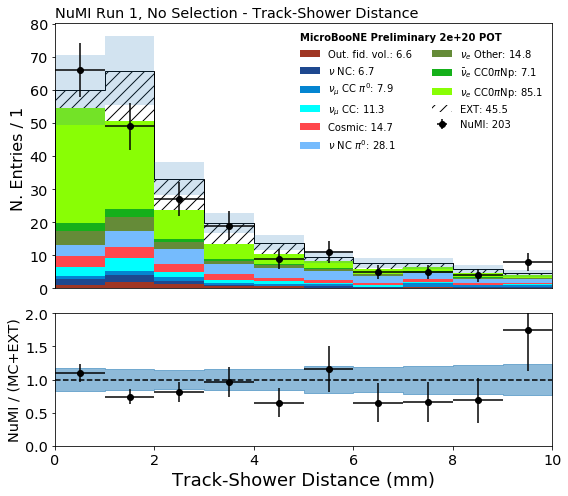

In [69]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'tksh_distance', 10, (0.0,10.0), r"Track-Shower Distance (mm)"

#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= BDT_LOOSE_CUTS,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True, 
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Track-Shower Distance',loc='left')
fig.tight_layout()

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  7.062867097808422  c  5
order w sum  7.327092618258835  c  3
order w sum  9.41698639417735  c  21
order w sum  11.622348238073027  c  2
order w sum  15.055693968545132  c  4
order w sum  31.403006513185307  c  31
order w sum  15.106247147697962  c  1
order w sum  7.258208614673398  c  12
order w sum  86.6759691334522  c  11
total  237.50874663474372
[1.992 0.764 0.233 0.185 0.259 0.521 0.313 0.543 0.875 1.378]
sum:  7.062867097808418
[2.597 1.442 0.891 0.298 0.877 1.087 0.987 1.663 1.908 2.64 ]
sum:  14.389959716067253
[3.606 1.979 1.331 1.027 1.175 1.963 2.164 2.91  3.01  4.643]
sum:  23.80694611

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


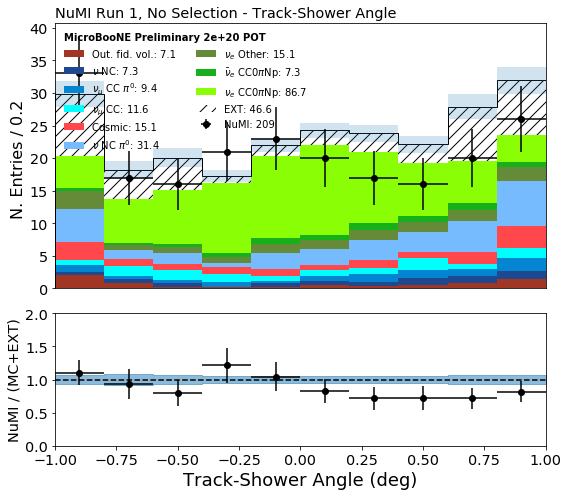

In [73]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'tksh_angle', 10, (-1.0,1.0), r"Track-Shower Angle (deg)"

reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERYB = 'nslice==1'
BDT_PRE_QUERYB += ' and ' + reco_in_fv_query
BDT_PRE_QUERYB +=' and contained_fraction>0.9'
BDT_PRE_QUERYB += ' and n_tracks_contained>0'
BDT_PRE_QUERYB += ' and n_showers_contained==1'
BDT_PRE_QUERYB += ' and shr_energy_tot_cali>0.07' #one
BDT_PRE_QUERYB += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTSB = BDT_PRE_QUERYB
BDT_LOOSE_CUTSB += ' and shr_score<0.3'
BDT_LOOSE_CUTSB += ' and trkpid<0.35'
BDT_LOOSE_CUTSB += ' and shrmoliereavg<15' #one
BDT_LOOSE_CUTSB += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTSB += ' and tksh_distance<12'

#OPEN_QUERY = "tksh_angle > 0"

#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= BDT_LOOSE_CUTSB,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True, 
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Track-Shower Angle',loc='left')
fig.tight_layout()

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12& subcluster <= 50 & subcluster >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  7.047127999633074  c  5
order w sum  7.327092618258835  c  3
order w sum  9.019005314692182  c  21
order w sum  11.622348238073027  c  2
order w sum  14.975826290444946  c  4
order w sum  31.173942076607833  c  31
order w sum  14.610845666520147  c  1
order w sum  6.889357660839249  c  12
order w sum  85.44745860070165  c  11
total  234.13212261670483
[0.    0.848 0.703 1.058 0.826 0.776 0.294 0.097 0.499 0.254 0.498 0.236
 0.181 0.194 0.045 0.286 0.126 0.054 0.009 0.015 0.018 0.013 0.01  0.
 0.009]
sum:  7.047127999633074
[0.    2.196 2.465 2.43  1.583 1.342 0.

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/NuMI/PELEE/plotter.py:459: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc

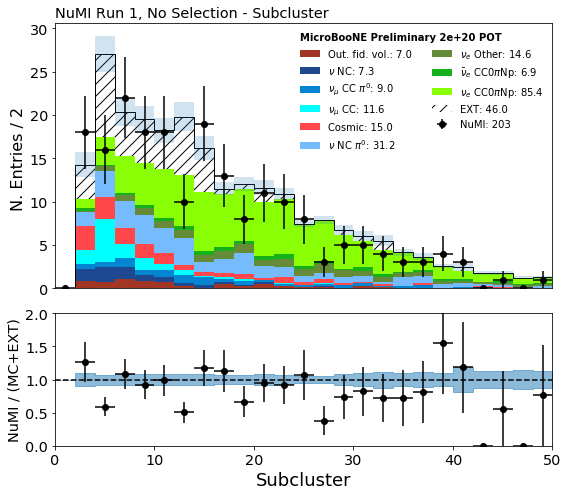

In [45]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'subcluster', 25, (0.0,50.0), r"Subcluster"


reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERYB = 'nslice==1'
BDT_PRE_QUERYB += ' and ' + reco_in_fv_query
BDT_PRE_QUERYB +=' and contained_fraction>0.9' #one
BDT_PRE_QUERYB += ' and n_tracks_contained>0'
BDT_PRE_QUERYB += ' and n_showers_contained==1'
BDT_PRE_QUERYB += ' and shr_energy_tot_cali>0.07' #one
BDT_PRE_QUERYB += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTSB = BDT_PRE_QUERYB
BDT_LOOSE_CUTSB += ' and shr_score<0.3'  #one
BDT_LOOSE_CUTSB += ' and trkpid<0.35'
BDT_LOOSE_CUTSB += ' and shrmoliereavg<15'  #one
BDT_LOOSE_CUTSB += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTSB += ' and tksh_distance<12'
#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#FID_QUERY = fiduc
#OPEN_QUERY = "subcluster > 0"

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= BDT_LOOSE_CUTSB,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True, 
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Subcluster',loc='left')
fig.tight_layout()

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12& trkshrhitdist2 <= 5 & trkshrhitdist2 >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  5.907281406193641  c  5
order w sum  6.225731274140132  c  3
order w sum  6.670303640964084  c  21
order w sum  9.784660889911333  c  4
order w sum  10.102227976420277  c  2
order w sum  22.921565829751824  c  31
order w sum  12.00151599210707  c  1
order w sum  6.4140549907085225  c  12
order w sum  78.2917475063339  c  11
total  190.30798870900924
[2.862 1.858 0.372 0.189 0.312 0.009 0.218 0.087 0.    0.   ]
sum:  5.9072814061936345
[5.203 4.366 0.762 0.321 0.559 0.166 0.218 0.087 0.276 0.175]
sum:  12.133012680333765
[7.005 6.681 1.619 0.575 0.753 0.51

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys
n_data  [50 76 17  8  3  6  3  1  2  1]


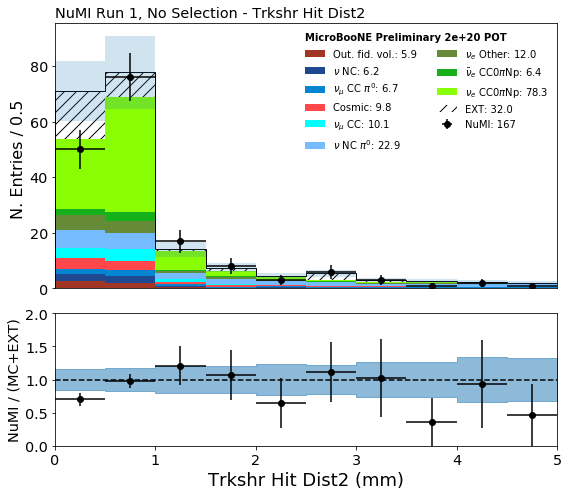

In [76]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'trkshrhitdist2', 10, (0.0,5.0), r"Trkshr Hit Dist2 (mm)"

#true nueCCNp in the fiducial volume. No abs(12) as only wants nu not anti!
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= BDT_LOOSE_CUTS,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True, 
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Trkshr Hit Dist2',loc='left')
fig.tight_layout()

In [ ]:
###Need to use the same BDT split value Katerina did
#It was BDT score > 0.575

BDT_score > 0& BDT_score <= 1 & BDT_score >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  1031.8050767746447  c  31
order w sum  1621.0241755387212  c  3
order w sum  2292.426430312701  c  21
order w sum  8688.79006847261  c  5
order w sum  11144.719402809247  c  4
order w sum  12403.516435949157  c  2
order w sum  62724.94094396818  c  0
order w sum  369.38976848798444  c  1
order w sum  32.4438671321362  c  12
order w sum  372.17504285471824  c  11
total  608217.1059537296


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[121.031 502.812 210.789  95.95   72.375  20.323   6.771   1.753   0.
   0.   ]
sum:  1031.8050767746458
[2.517e+02 8.929e+02 6.755e+02 1.415e+02 6.553e+02 2.545e+01 8.296e+00
 2.102e+00 9.573e-02 0.000e+00]
sum:  2652.8292523133605
[4.850e+02 1.935e+03 1.262e+03 3.708e+02 7.993e+02 6.585e+01 2.316e+01
 3.660e+00 9.573e-02 0.000e+00]
sum:  4945.255682626072
[6.980e+02 9.690e+03 1.750e+03 4.094e+02 9.895e+02 6.859e+01 2.405e+01
 4.316e+00 1.626e-01 0.000e+00]
sum:  13634.045751098749
[1.458e+03 1.768e+04 3.641e+03 5.157e+02 1.379e+03 7.553e+01 2.628e+01
 4.942e+00 3.141e-01 0.000e+00]
sum:  24778.765153907745
[2.366e+03 2.166e+04 8.471e+03 9.352e+02 3.619e+03 9.460e+01 3.224e+01
 8.412e+00 5.912e-01 0.000e+00]
sum:  37182.281589856895
[2.366e+03 8.438e+04 8.471e+03 9.352e+02 3.619e+03 9.460e+01 3.224e+01
 8.412e+00 5.912e-01 0.000e+00]
sum:  99907.22253381902
[2.383e+03 8.456e+04 8.546e+03 9.750e+02 3.649e+03 1.090e+02 4.109e+01
 1.373e+01 1.177e+00 0.000e+00]
sum:  100276.61230230701
[

/home/alex/NuMI/PELEE/plotter.py:256: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/home/alex/NuMI/PELEE/plotter.py:2286: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


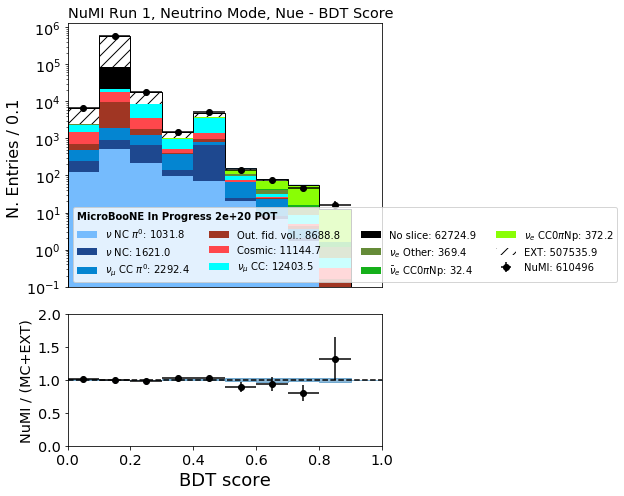

In [58]:
import matplotlib.pyplot as plt
import matplotlib

SEL_QUERY = BDT_LOOSE_CUTS
#SEL_QUERY += ' and BDT_score > 0.575'
SEL_QUERY = "BDT_score > 0"

VARIABLE, BINS, RANGE, XTIT = 'BDT_score',10,(0.0, 1.0),"BDT score"
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = True, 
    draw_data = True,
    #genieweight = "totweight_overlay",
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before.
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, Neutrino Mode, Nue - BDT Score',loc='left')
ax1.set_yscale("log")
fig.tight_layout()

In [33]:
"""overlap_list = [590, 2000, 2680, 3462, 3497, 4256, 5493, 6685, 6758, 7258, 7288, 7880, 8846, 8908, 10409, 11348, 11364, 11852, 12220, 12946, 14608, 15392, 15546, 15948, 16523, 17762, 18098, 18313, 18438, 18447, 18808, 19139, 19466, 19687, 19894, 20772, 20970, 21405, 22301, 22534, 23201, 23301, 23450, 23467, 23489, 23710, 23790, 25500, 25850, 26643, 27859, 27948, 28578, 29334, 30148, 30250, 30369, 30504, 30630, 31077, 31609, 33044, 33422, 33973, 34864, 35141, 35212, 35540, 35745, 36318, 36583, 36615, 37003, 37736, 38596, 39289, 39699, 40243, 40674, 40890, 41018, 41399, 42735, 43188, 43299, 43302, 43786, 43922, 44150, 44475, 44975, 46200, 46324, 46911, 47233, 48502, 49584, 49769, 49804, 51322, 51979, 52183, 52365, 53359, 55214, 56421, 56593, 56958, 58356, 58477, 61415, 62899, 63167, 63852, 64887, 65304, 66603, 66676, 67869, 68165, 69003, 69693, 70419, 70582, 71640, 72065, 72086, 72293, 73106, 73944, 74433, 75756, 76092, 76747, 78072, 78409, 78823, 80575, 80855, 81005, 81929, 81977, 83183, 84027, 84097, 84185, 84850, 85355, 85455, 85815, 85871, 86604, 87249, 88329, 88717, 89528, 89661, 90340, 91421, 91780, 92022, 92216, 93197, 93663, 94155, 94536, 95864, 96944, 97560, 97901, 98181, 100062, 102022, 102043, 102179, 102983, 103605, 104483, 104972, 105246, 106536, 107074, 107112, 107687, 108965, 109277, 109337, 109692, 112459, 113496, 114722, 114847, 115871, 116025, 117210, 117394, 118306, 119872, 121226, 121378, 121913, 122882, 122936, 123600, 123788, 124169, 124820, 124944, 125226, 125354, 125425, 125544, 126733, 127424]

datasetlist = [nue]
#datasetlist = [mc, nue, dirt, ext, data]
count = 0

#print(nue['shr_score'].size)
#print(mc['shr_score'].size)

#we only care about the overlap value in the nue and mc part, so the rest can be 0s
overlap_df = [0]*(nue['shr_score'].size)
overlapmc_df = [0]*(mc['shr_score'].size)
overlapdirt_df = [0]*(dirt['shr_score'].size)
overlapext_df = [0]*(ext['shr_score'].size)
overlapdata_df = [0]*(data['shr_score'].size)

   
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['shr_score'].size):
            if df.index[i] == j:
                count = count + 1
                overlap_df[i] = 1                
                #print("overlap")
                #print(df.index[i])
                #print(j)
                
print(count)
print(len(overlap_df))


#mc
datasetlist = [mc]
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['shr_score'].size):
            if df.index[i] == j:
                count = count + 1
                overlapmc_df[i] = 1  
                
#dirt
datasetlist = [dirt]
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['shr_score'].size):
            if df.index[i] == j:
                count = count + 1
                overlapdirt_df[i] = 1  

                
#dirt
datasetlist = [ext]
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['shr_score'].size):
            if df.index[i] == j:
                count = count + 1
                overlapext_df[i] = 1    
                
#dirt
datasetlist = [data]
for df in datasetlist:
    for j in overlap_list:
        for i in range(df['shr_score'].size):
            if df.index[i] == j:
                count = count + 1
                overlapdata_df[i] = 1"""

214
127551


In [34]:
"""nue['overlap'] = overlap_df
mc['overlap'] = overlapmc_df
dirt['overlap'] = overlapdirt_df
ext['overlap'] = overlapext_df
data['overlap'] = overlapdata_df

SEL_QUERY += ' and overlap == 0'"""

In [51]:
"""Save the DataFrame to a csv file to check for any crossover in datapoints

#SEL_QUERY += ' and overlap == 0'
#SEL_QUERY += ' & reco_e <= 5 & reco_e >= 0'
SEL_QUERY = "nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575"
print(SEL_QUERY)
selected = dirt.query(SEL_QUERY)

#fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and (nu_pdg == 12 and ccnc == 0) and nproton > 0"
#fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < 254.8 and true_nu_vtx_x > -1.55"
selected_fid = selected#.query(fiduc_q)
#print(selected_fid["nu_pdg"].size)
selected_fid.to_csv('nue_dirtdf.csv')

#Shouldn't be abs pdg if only want nue not anti??
#Will give how many true nueCC's in fidual vol there are
#But we want to check whole dataset xover"""

nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575


nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_tracks_contained>0 and n_showers_contained==1 and shr_energy_tot_cali>0.07 and trk_energy>0.04 and shr_score<0.3 and trkpid<0.35 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  0.4789296166403314  c  3
order w sum  0.4849670167220518  c  4
order w sum  0.6081289599520437  c  5
order w sum  0.8618336019701214  c  21
order w sum  1.9404238859110692  c  2
order w sum  2.124404610494145  c  31
order w sum  4.023855822156849  c  1
order w sum  3.7460561473004157  c  12
order w sum  57.03751092595994  c  11
total  71.86731934504519
[0.303 0.087 0.089 0.    0.    0.    0.    0.    0.    0.   ]
sum:  0.47892961664033135
[0.482 0.188 0.207 0.033 0.054 0.    0.    0.    0.    0.   ]
sum:  0.9638966333623833
[0.707 0.485 0.272 0.055 

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


data
dirt
ext
Universes 500
mc
nue
data
dirt
ext
Universes 500
mc
nue
data
dirt
ext
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys
n_data  [21 26  7  4  2  0  0  1  0  0]


/home/alex/NuMI/PELEE/plotter.py:458: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/alex/NuMI/PELEE/plotter.py:266: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


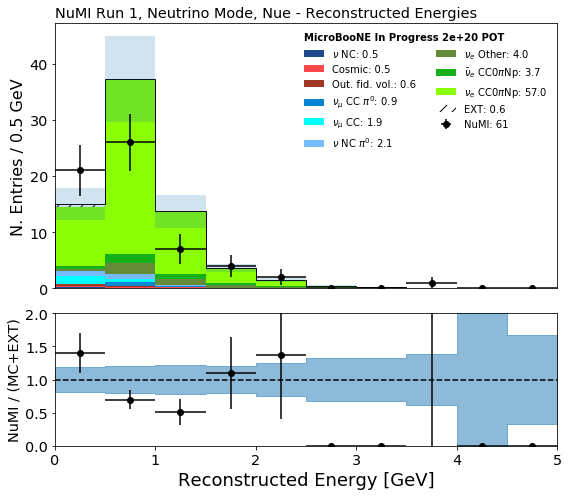

In [34]:
#Now check on a variable


import matplotlib.pyplot as plt
import matplotlib

VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = True, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, Neutrino Mode, Nue - Reconstructed Energies',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

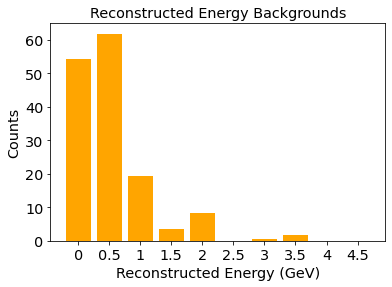

In [69]:
"""#Background numbers plot

bkg_nums = [54.235, 61.865, 19.335, 3.661, 8.327, 0, 0.582, 1.726, 0, 0]

import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 5, 0.5)
names = ['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5']
#gen = plt.hist(bkg_nums, bins, color='orange')
plt.bar(names, bkg_nums, color='orange')
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Counts")
plt.title("Reconstructed Energy Backgrounds")
plt.show()"""

In [35]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)['nu_e'], bins, color='deepskyblue')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylabel('Selected Signal Events', fontsize=15)
    ax1.set_xlabel('True Nue Energy [GeV]', fontsize=15)

    # compute efficiency
    #sel2=selected['nu_e']
    sel = ax1.hist(selected['nu_e'], bins, color='white')
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        print("In bin", i, ", eff = ", eff[i], " with error = ", eff_err[i])
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    sel = ax1.hist(truth['nu_e'], bins, color='deepskyblue')
    ax1.set_ylim(0, 3500)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='orangered', ecolor='orangered', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("True Nue Energy and Efficiency")
    plt.text(0, 0.95, r'MicroBooNE In Progress', fontweight='bold')

    plt.show()

In bin 0 , eff =  0.07940645678764788  with error =  0.0038286193241208162
In bin 1 , eff =  0.1022562249849467  with error =  0.0018031944624550325
In bin 2 , eff =  0.08028610463714539  with error =  0.0017225388239379188
In bin 3 , eff =  0.055296904353508126  with error =  0.0020656377131937605
In bin 4 , eff =  0.041173609985410926  with error =  0.0025297178047228677
In bin 5 , eff =  0.027177089421391  with error =  0.002779574789726137
In bin 6 , eff =  0.021266540642722116  with error =  0.003136337648119552
In bin 7 , eff =  0.01864406779661017  with error =  0.003937699850468241
In bin 8 , eff =  0.016200294550810016  with error =  0.004844845279667156
In bin 9 , eff =  0.0125  with error =  0.006210814660734935


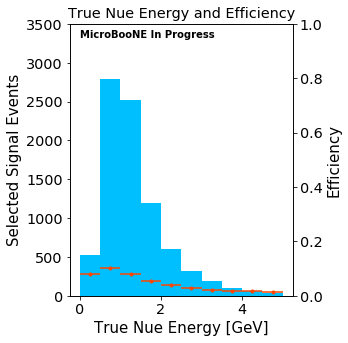

In [36]:
#SEL_QUERY = "BDT_score > 0.575"
#selected = nue.query(SEL_QUERY)


fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 12 and ccnc == 0) and nproton > 0"


#bins = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.05, 2.25, 2.45, 2.65, 2.85, 3.05]
bins = np.arange(0, 5.5, 0.5)
#plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

selected = nue.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

plot_signal_and_eff(selected_fid, nue, fiduc_q, bins, mc.query(fiduc_q))

### Smearing Matrix work

In [37]:
# plot the smearing matrix 
def plot_smearing(selected, signal, true, reco, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(selected.query(signal)[true],selected.query(signal)[reco],
                   bins, cmin=0.000000001, cmap='OrRd')

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1): 
                norm_array[i][j] =  norm_array[i][j] / tot_reco_events
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)

    plt.xlabel('True Nu Energy [GeV]', fontsize=15)
    plt.ylabel('Reco Nu Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()

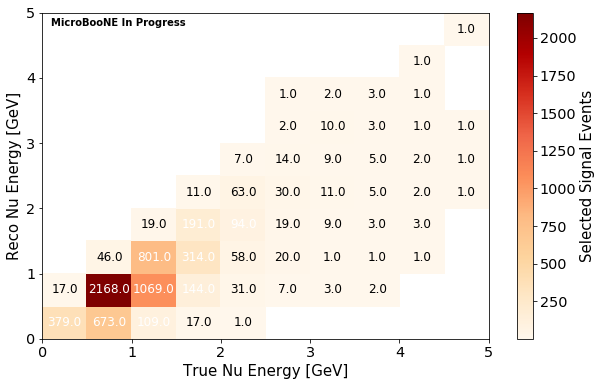

In [38]:
# true nu energy 
true_var = 'nu_e'

# reconstructed nu energy 
reco_var = 'reco_e'

bins = np.arange(0, 5.5, 0.5)

# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins)

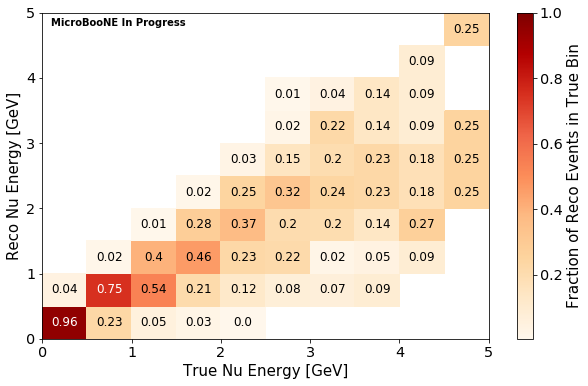

In [39]:
# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins, norm=True)

In [60]:
# Calculate true numbers
#bkg_nums = [54.235, 61.865, 19.335, 3.661, 8.327, 0, 0.582, 1.726, 0, 0]
#n_data = [73, 112, 39, 10, 11, 0, 1, 2, 0, 0]
#mc numbers
#n_selected = [10.449224075510084, 31.07824842226588, 11.142672530720944, 2.7208182211142926, 1.0626423368548643, 0.3260199520259164, 0.13695140632728453, 0.0804829838961254, 0.020303320127453617, 0.02014767711723664]
#no Presel
n_selected = [15.559646755457432, 43.60474738642585, 17.684595126428704, 5.431724662289086, 2.4800015797165145, 1.0062859860206572, 0.40533515637322637, 0.2751028386181531, 0.0797978973746325, 0.06167967723932577]

#true0 = (n_selected[0]*0.96) + (n_selected[1]*0.04)
#true05 = (n_selected[0]*0.23) + (n_selected[1]*0.75) + (n_selected[2]*0.02)
#true1 = (n_selected[0]*0.05) + (n_selected[1]*0.54) + (n_selected[2]*0.4) + (n_selected[3]*0.01)
#true15 = (n_selected[0]*0.03) + (n_selected[1]*0.21) + (n_selected[2]*0.46) + (n_selected[3]*0.28) + (n_selected[4]*0.02)
#true2 = (n_selected[0]*0.0) + (n_selected[1]*0.12) + (n_selected[2]*0.23) + (n_selected[3]*0.37) + (n_selected[4]*0.25) + (n_selected[5]*0.03)
#true25 = (n_selected[1]*0.08) + (n_selected[2]*0.22) + (n_selected[3]*0.2) + (n_selected[4]*0.32) + (n_selected[5]*0.15) + (n_selected[6]*0.02 )+ (n_selected[7]*0.01)
#true3 = (n_selected[1]*0.07) + (n_selected[2]*0.02) + (n_selected[3]*0.2) + (n_selected[4]*0.24) + (n_selected[5]*0.2) + (n_selected[6]*0.22) + (n_selected[7]*0.04)
#true35 = (n_selected[1]*0.09) + (n_selected[2]*0.05) + (n_selected[3]*0.14) + (n_selected[4]*0.23) + (n_selected[5]*0.23) + (n_selected[6]*0.14) + (n_selected[7]*0.14)
#true4 = (n_selected[2]*0.09) + (n_selected[3]*0.27) + (n_selected[4]*0.18) + (n_selected[5]*0.18) + (n_selected[6]*0.09) + (n_selected[7]*0.09) + (n_selected[8]*0.09)
#true45 = (n_selected[4]*0.25) + (n_selected[5]*0.25) + (n_selected[6]*0.25) + (n_selected[9]*0.25)


#No Presel
true0 = (n_selected[0]*0.95) + (n_selected[1]*0.05)
true05 = (n_selected[0]*0.24) + (n_selected[1]*0.74) + (n_selected[2]*0.02)
true1 = (n_selected[0]*0.06) + (n_selected[1]*0.52) + (n_selected[2]*0.4) + (n_selected[3]*0.01)
true15 = (n_selected[0]*0.03) + (n_selected[1]*0.21) + (n_selected[2]*0.45) + (n_selected[3]*0.29) + (n_selected[4]*0.02)
true2 = (n_selected[0]*0.01) + (n_selected[1]*0.11) + (n_selected[2]*0.24) + (n_selected[3]*0.36) + (n_selected[4]*0.25) + (n_selected[5]*0.03)
true25 = (n_selected[1]*0.07) + (n_selected[2]*0.13) + (n_selected[3]*0.23) + (n_selected[4]*0.35) + (n_selected[5]*0.19) + (n_selected[6]*0.02)
true3 = (n_selected[0]*0.01) + (n_selected[1]*0.05) + (n_selected[2]*0.05) + (n_selected[3]*0.15) + (n_selected[4]*0.21) + (n_selected[5]*0.28) + (n_selected[6]*0.2) + (n_selected[7]*0.05) + (n_selected[8]*0.01)
true35 = (n_selected[1]*0.07) + (n_selected[2]*0.06) + (n_selected[3]*0.09) + (n_selected[4]*0.16) + (n_selected[5]*0.26) + (n_selected[6]*0.2) + (n_selected[7]*0.16) + (n_selected[8]*0.01)
true4 = (n_selected[1]*0.07) + (n_selected[2]*0.05) + (n_selected[3]*0.12) + (n_selected[4]*0.12) + (n_selected[5]*0.21) + (n_selected[6]*0.07) + (n_selected[7]*0.17) + (n_selected[8]*0.17) + (n_selected[9]*0.02)
true45 = (n_selected[3]*0.09) + (n_selected[4]*0.09) + (n_selected[5]*0.09) + (n_selected[6]*0.18) + (n_selected[7]*0.27) + (n_selected[8]*0.18) +(n_selected[9]*0.09)

In [62]:
#multiply by efficiency and sum

#eff = [0.07940645678764788, 0.1022562249849467, 0.08028610463714539, 0.055296904353508126, 0.041173609985410926, 0.027177089421391, 0.021266540642722116, 0.01864406779661017, 0.016200294550810016, 0.0125]
#no presel
eff = [0.10828153198315621, 0.14975383416569263, 0.14044040826167323, 0.12178387650085763, 0.10455503323066948, 0.09029807130333138, 0.07986767485822306, 0.059322033898305086, 0.06480117820324006, 0.034375]
truths = [true0, true05, true1, true15, true2, true25, true3, true35, true4, true45]
ratio_nums = []
for i in range(len(truths)):
    num = truths[i]*(1/eff[i])
    ratio_nums.append(num)
    
print("Numbers of Ratio, nue: ", ratio_nums)
print("Ratio number, nue: ", sum(ratio_nums))


Numbers of Ratio, nue:  [156.64630409592255, 242.7685434054966, 218.85583447033667, 157.71097863048374, 112.8786534580355, 84.9179593595739, 61.7646984377976, 90.8023370712979, 80.0483818799853, 28.2116069112849]
Ratio number, nue:  1234.6052977202144


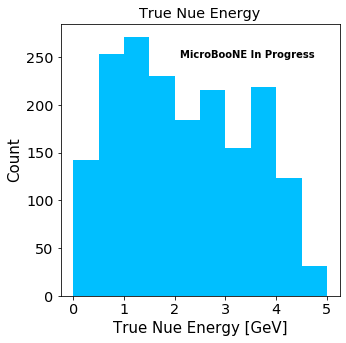

In [60]:
import matplotlib.pyplot as plt
import matplotlib

nue_truth = [141.98322788196882, 253.62623457397393, 271.3918260796732, 230.54853346258034, 183.9612416790349, 216.1491167152742, 154.98906567684202, 219.10045174329113, 123.99879811416274, 30.915227446506037]
#no presel
#nue_truth = [156.64630409592255, 242.7685434054966, 218.85583447033667, 157.71097863048374, 112.8786534580355, 84.9179593595739, 61.7646984377976, 90.8023370712979, 80.0483818799853, 28.2116069112849]
count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
weights = [0.1*nue_truth[0], 0.6*nue_truth[1], 1.1*nue_truth[2], 1.6*nue_truth[3], 2.1*nue_truth[4], 2.6*nue_truth[5], 3.1*nue_truth[6], 3.6*nue_truth[7], 4.1*nue_truth[8], 4.6*nue_truth[9]]
bins = np.arange(0, 5.5, 0.5)    
    
# plot selected signal events 
fig, ax1 = plt.subplots(figsize=(5, 5))
    
sel = ax1.hist(count, bins, color='deepskyblue', weights=nue_truth)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xlabel('True Nue Energy [GeV]', fontsize=15)
#ax1.set_ylim(0, 3500)
ax1.set_title("True Nue Energy")
    
plt.text(2.1, 250, r'MicroBooNE In Progress', fontweight='bold')
plt.show()

In [86]:
numu_ratio_nums = [1250.7791092142888, 1126.4765890497615, 843.9206593785316, 681.7782953189057, 685.5350914033968, 675.4858086753779, 539.1810416459871, 583.8058667644001, 564.5980366563023, 347.7409423924605]
#nue_ratio_nums = [141.98322788196882, 253.62623457397393, 271.3918260796732, 230.54853346258034, 183.9612416790349, 216.1491167152742, 154.98906567684202, 219.10045174329113, 123.99879811416274, 30.915227446506037]
#no presel
nue_ratio_nums = [156.64630409592255, 242.7685434054966, 218.85583447033667, 157.71097863048374, 112.8786534580355, 84.9179593595739, 61.7646984377976, 90.8023370712979, 80.0483818799853, 28.2116069112849]
bin_ratios = []

for i in range(len(numu_ratio_nums)):
    ratio = nue_ratio_nums[i]/numu_ratio_nums[i]
    bin_ratios.append(ratio)
    
print(bin_ratios)

[0.12523898339997397, 0.21551139701028657, 0.25933223939736644, 0.2313229677643427, 0.16465773214753365, 0.12571390585702652, 0.11455280076103042, 0.15553515687423192, 0.14177941948585726, 0.08112822929962982]


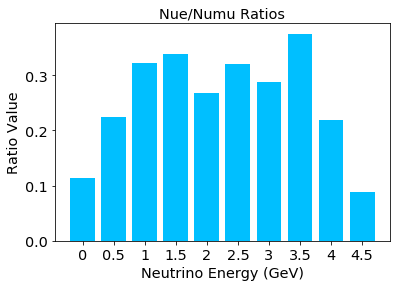

In [74]:
bins = np.arange(0, 5.5, 0.5)
names = ['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5']
#gen = plt.hist(bkg_nums, bins, color='orange')
plt.bar(names, bin_ratios, color='deepskyblue')
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel("Ratio Value")
plt.title("Nue/Numu Ratios")
plt.show()

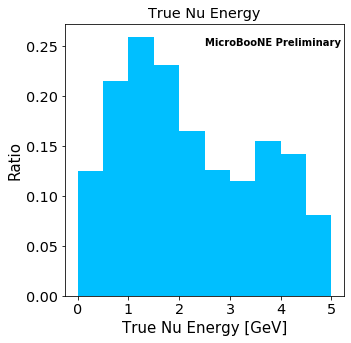

In [90]:
    count = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6]
    
    weights = [0.1*0.11351582932270068, 0.6*0.2251500271194452, 1.1*0.3215845270093611, 1.6*0.33815763136715865, 2.1*0.268346936554973, 2.6*0.3199906111116395, 3.1*0.2874527361045532, 3.6*0.37529676253101274, 4.1*0.21962314790982299, 4.6*0.0889030415395122]
    
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(5, 5))
    
    sel = ax1.hist(count, bins, color='deepskyblue', weights=bin_ratios)
    ax1.set_ylabel('Ratio', fontsize=15)
    ax1.set_xlabel('True Nu Energy [GeV]', fontsize=15)
    #ax1.set_ylim(0, 3500)
    ax1.set_title("True Nu Energy")
    
    plt.text(2.5, 0.25, r'MicroBooNE Preliminary', fontweight='bold')
    plt.show()